In [2]:
!nvidia-smi

Tue Jun  1 02:22:15 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import os
import librosa
import librosa.display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.utils import shuffle
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix
from keras import regularizers
from google.colab import files #匯入套件
import pandas as pd
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras.applications.vgg16 import VGG16
from keras.layers.normalization import BatchNormalization
from sklearn.metrics import confusion_matrix

In [4]:
import os
PATH = "/content/drive/MyDrive/Speech_Actor_01"

folder= os.listdir(PATH)
print(PATH)

/content/drive/MyDrive/Speech_Actor_01


In [5]:
feeling_list=[]
for item in folder:
    if item[6:-16]=='01':
        feeling_list.append('neutral')
    elif item[6:-16]=='02':
        feeling_list.append('calm')
    elif item[6:-16]=='03':
        feeling_list.append('happy')
    elif item[6:-16]=='04':
        feeling_list.append('sad')
    elif item[6:-16]=='05':
        feeling_list.append('angry')
    elif item[6:-16]=='06':
        feeling_list.append('fearful')
    elif item[6:-16]=='07':
        feeling_list.append('disgust')
    elif item[6:-16]=='08':
        feeling_list.append('surprised')

In [6]:
labels = pd.DataFrame(feeling_list)

df = pd.DataFrame(columns=['feature'])
bookmark = 0

for index, y in enumerate(folder):
  X, sample_rate = librosa.load(os.path.join('/', PATH, y), sr = 22050 * 2, offset=0.5, duration = 2.5, res_type='kaiser_fast')
  sample_rate = np.array(sample_rate)
  a = librosa.feature.mfcc(y = X, sr=sample_rate, n_mfcc=13)
  mfccs = np.mean(librosa.feature.mfcc(y = X, sr=sample_rate, n_mfcc=13), axis=0)
  feature = mfccs
  df.loc[bookmark] = [feature] #用index的標籤來取出資料
  bookmark = bookmark+1
df3 = pd.DataFrame(df['feature'].values.tolist())
newdf = pd.concat([df3, labels], axis = 1)
rnewdf = newdf.rename(index = str, columns={'0':'label'})

rnewdf = shuffle(newdf)
rnewdf = rnewdf.fillna(0)

newdf1 = np.random.rand(len(rnewdf)) < 0.8

In [7]:
train = rnewdf[newdf1]
test = rnewdf[~newdf1]
        
trainfeatures = train.iloc[:, :-1]
trainlabel = train.iloc[:, -1:]

testfeatures = test.iloc[:, :-1]        
testlabel = test.iloc[:, -1:]        
        
X_train, y_train = np.array(trainfeatures), np.array(trainlabel)
X_test, y_test = np.array(testfeatures), np.array(testlabel)

        
lb = LabelEncoder()

Y_train, Y_test = np_utils.to_categorical(lb.fit_transform(y_train)), np_utils.to_categorical(lb.fit_transform(y_test))        
        
x_traincnn, x_testcnn =np.expand_dims(X_train, axis=2), np.expand_dims(X_test, axis=2)


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [8]:
#"""
model = Sequential()

model.add(Conv1D(256, 5,padding='same',input_shape=(216,1)))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))

#
#model.add(Conv1D(128, 5,padding='same',))
#model.add(Activation('relu'))
#model.add(Conv1D(128, 5,padding='same',))
#model.add(Activation('relu'))
#model.add(Dropout(0.2))
#
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(64, 5,padding='same',))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(8))
model.add(Dropout(0.25))
model.add(Activation('softmax'))
opt = keras.optimizers.RMSprop(lr=0.00001, decay=1e-6)

model.summary()      
        
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
#"""

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 216, 256)          1536      
_________________________________________________________________
activation (Activation)      (None, 216, 256)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 216, 128)          163968    
_________________________________________________________________
activation_1 (Activation)    (None, 216, 128)          0         
_________________________________________________________________
dropout (Dropout)            (None, 216, 128)          0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 27, 128)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 27, 128)           8

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/400
37/37 [==============================] - 45s 42ms/step - loss: 2.7038 - accuracy: 0.1426 - val_loss: 2.0745 - val_accuracy: 0.1051
Epoch 2/400
37/37 [==============================] - 0s 9ms/step - loss: 2.1006 - accuracy: 0.1433 - val_loss: 2.0695 - val_accuracy: 0.1486
Epoch 3/400
37/37 [==============================] - 0s 8ms/step - loss: 2.0830 - accuracy: 0.1656 - val_loss: 2.0679 - val_accuracy: 0.1630
Epoch 4/400
37/37 [==============================] - 0s 9ms/step - loss: 2.0683 - accuracy: 0.1776 - val_loss: 2.0677 - val_accuracy: 0.1449
Epoch 5/400
37/37 [==============================] - 0s 8ms/step - loss: 2.0454 - accuracy: 0.1615 - val_loss: 2.0479 - val_accuracy: 0.1667
Epoch 6/400
37/37 [==============================] - 0s 8ms/step - loss: 2.0659 - accuracy: 0.1779 - val_loss: 2.0549 - val_accuracy: 0.1848
Epoch 7/400
37/37 [==============================] - 0s 8ms/step - loss: 2.0503 - accuracy: 0.1856 - val_loss: 2.0363 - val_accuracy: 0.1522
Epoch 8/400

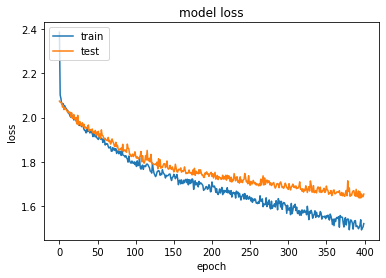

In [9]:

cnnhistory=model.fit(x_traincnn, Y_train, batch_size=32, epochs=400, validation_data=(x_testcnn, Y_test))
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [10]:
model_name = 'Emotion_Voice_Detection_Model.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at /content/saved_models/Emotion_Voice_Detection_Model.h5 


In [11]:
import json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [13]:
from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("saved_models/Emotion_Voice_Detection_Model.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn, Y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
accuracy: 40.58%


In [15]:
preds = loaded_model.predict(x_testcnn, 
                         batch_size=32, 
                         verbose=1)

9/9 [==============================] - 1s 3ms/step


In [17]:
preds1=preds.argmax(axis=1)

In [18]:
abc = preds1.astype(int).flatten()

In [19]:
predictions = (lb.inverse_transform((abc)))

In [20]:
preddf = pd.DataFrame({'predictedvalues': predictions})
preddf[:10]

,predictedvalues
0,sad
1,disgust
2,calm
3,calm
4,angry
5,calm
6,sad
7,happy
8,calm
9,sad


In [21]:
actual=y_test.argmax(axis=1)
abc123 = actual.astype(int).flatten()
actualvalues = (lb.inverse_transform((abc123)))

actualdf = pd.DataFrame({'actualvalues': actualvalues})

In [22]:
finaldf = actualdf.join(preddf)
finaldf.groupby('actualvalues').count()

finaldf.groupby('predictedvalues').count()

finaldf.to_csv('Predictions.csv', index=False)

In [23]:
data, sampling_rate = librosa.load('/content/drive/MyDrive/工研院語音/output10.wav')

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['test', 'shuffle']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


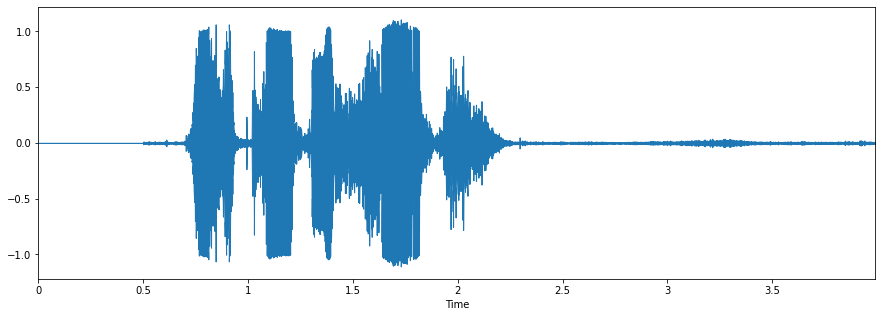

In [24]:

% pylab inline
import os
import pandas as pd
import librosa
import glob 

plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

In [25]:
X, sample_rate = librosa.load('/content/drive/MyDrive/工研院語音/output10.wav', res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
sample_rate = np.array(sample_rate)
mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13),axis=0)
featurelive = mfccs
livedf2 = featurelive

livedf2= pd.DataFrame(data=livedf2)
livedf2 = livedf2.stack().to_frame().T

In [26]:
twodim= np.expand_dims(livedf2, axis=2)

livepreds = loaded_model.predict(twodim, 
                         batch_size=32, 
                         verbose=1)

1/1 [==============================] - 0s 82ms/step


In [27]:
livepreds1=livepreds.argmax(axis=1)
liveabc = livepreds1.astype(int).flatten()

livepredictions = (lb.inverse_transform((liveabc)))
livepredictions

array(['angry'], dtype=object)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Confusion matrix, without normalization
[[20  4  4  3  3  1  0  1]
 [ 3 12  4  2  0  4  6  1]
 [ 4  9  8  4  3  1  4  4]
 [ 3  2  4 16  4  0  3  4]
 [ 9  5  2  8  8  0  6  9]
 [ 2  2  0  2  1  3  2  2]
 [ 3  6  6  2  3  3  7  5]
 [ 1  3  2  7  6  5  4 11]]
Normalized confusion matrix
[[0.56 0.11 0.11 0.08 0.08 0.03 0.   0.03]
 [0.09 0.38 0.12 0.06 0.   0.12 0.19 0.03]
 [0.11 0.24 0.22 0.11 0.08 0.03 0.11 0.11]
 [0.08 0.06 0.11 0.44 0.11 0.   0.08 0.11]
 [0.19 0.11 0.04 0.17 0.17 0.   0.13 0.19]
 [0.14 0.14 0.   0.14 0.07 0.21 0.14 0.14]
 [0.09 0.17 0.17 0.06 0.09 0.09 0.2  0.14]
 [0.03 0.08 0.05 0.18 0.15 0.13 0.1  0.28]]


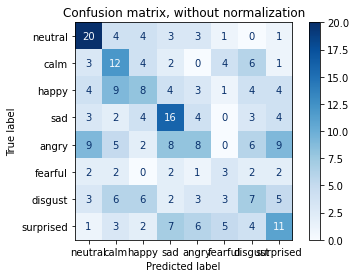

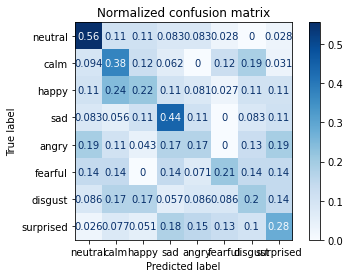

<Figure size 3600x3600 with 0 Axes>

In [30]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix

# import some data to play with
#X = iris.data
#y = iris.target
class_names = ['neutral','calm' , 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']

# Split the data into a training set and a test set
#X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
#x_traincnn, x_testcnn, y_train, y_test
# Run classifier, using a model that is too regularized (C too low) to see
# the impact on the results
classifier = svm.SVC(kernel='linear', C=0.01).fit(X_train, y_train)

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(classifier, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)
plt.figure(figsize=(50,50))
plt.show()